In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords

In [3]:
df = pd.read_csv('twitter_training.csv', header=None, names=['cat','source','label','text'])

In [2]:
# string processing functions
def decontract(sentence):
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence
def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

In [4]:
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1',x))

In [5]:
df['token_size'] = df['text'].apply(lambda x: len(x.split(' ')))
df = df.sample(10000)

In [6]:
# Construct a vocabulary
class ConstructVocab():
    
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for sent in self.sentences:
            self.vocab.update(sent.split(' '))
        
        #sort vacabulary
        self.vocab = sorted(self.vocab)
        
        #add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        #word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # 0 is the pad
            
        #index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
            
inputs = ConstructVocab(df['text'].values.tolist())

In [7]:
# computing the word mapping for each tweet
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')] for es in df['text']]

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
        
    return padded

# padding the tweets up to the length of the longest tweet
input_tensor = [pad_sequences(x, max_length_input) for x in input_tensor]

In [9]:
from sklearn import preprocessing
rates = list(set(df['label'].unique()))
num_rates = len(rates)

mlb = preprocessing.MultiLabelBinarizer()
data_labels = [set(rat) & set(rates) for rat in df[['label']].values]
bin_rates = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_rates.tolist())

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=1000)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1000)

In [11]:
embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = len(target_tensor[0])

In [12]:
# Use Dataset class to represent the dataset object
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [np.sum(1 - np.equal(x,0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [13]:
TRAIN_BUFFER_SIZE = len(X_train)
VAL_BUFFER_SIZE = len(X_val)
TEST_BUFFER_SIZE = len(X_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE
train_dataset = MyData(X_train, y_train)
val_dataset = MyData(X_val, y_val)
test_dataset = MyData(X_test, y_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                          drop_last=True, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                          drop_last=True, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                          drop_last=True, shuffle=True)

In [14]:
import torch.nn as nn

class RateGRU(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(RateGRU, self).__init__()
        self.batch = batch_sz
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size
        
        #layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
        
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden)
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out, self.hidden

In [15]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RateGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

#loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    target = torch.max(y, 1)[1] 
    loss = criterion(prediction, target)
    
    return loss

def accuracy(target, logit):
    target = torch.max(target, 1)[1]
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100. * corrects / len(logit)
    
    return accuracy

In [35]:
import time
import matplotlib.pyplot as plt

val_losses = []
train_losses = []
train_acc = []

EPOCHS=10
for epoch in range(EPOCHS):
    print(epoch)
    start = time.time()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    i=0
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        if np.random.rand()<0.1:
            i+=1
            loss = 0
            predictions, _ = model(inp.permute(1, 0).to(device), lens, device)

            loss += loss_function(targ.to(device), predictions)
            batch_loss = (loss / int(targ.shape[1]))
            total_loss += batch_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_accuracy = accuracy(targ.to(device), predictions)
            train_accuracy += batch_accuracy
    train_losses.append(total_loss.item()/i)
    train_acc.append(train_accuracy.item()/i)

0
1
2
3
4
5
6
7
8
9


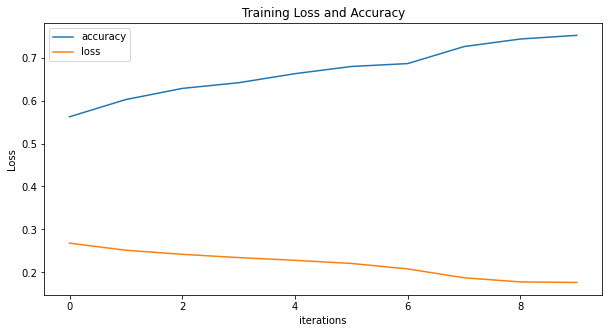

In [36]:
plt.figure(figsize=(10,5))
plt.title("Training Loss and Accuracy")
plt.plot([el/100 for el in train_acc],label="accuracy")
plt.plot(train_losses,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()